In [11]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [13]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(cv2.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = "/Users/bedabrata/DL/imgloading/"
train_data_directory = os.path.join(ROOT_PATH, "Traffic/Training")
test_data_directory = os.path.join(ROOT_PATH, "Traffic/Testing")
train_data_directory = os.path.join(ROOT_PATH, "Traffic/Training")
test_data_directory = os.path.join(ROOT_PATH, "Traffic/Testing")

x_train, y_train = load_data(train_data_directory)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = load_data(test_data_directory)
x_test = np.array(x_test)
y_test = np.array(y_test)
#Preprocess
x_test = [cv2.resize(image, (30, 30)) for image in x_test]
x_train = [cv2.resize(image, (30, 30)) for image in x_train]
x_test = np.array(x_test)
x_train = np.array(x_train)

y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])

In [14]:
NUM_CLASSES = 62
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)

y_train2 = np.eye(NUM_CLASSES)[y_train[:,0]]
y_test2 = np.eye(NUM_CLASSES)[y_test[:,0]]

In [15]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    model.add(Conv2D(16, (3, 3), input_shape=(30,30,3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(BatchNormalization())
    model.add(Activation("softmax"))
    
    return model

In [16]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
__________

In [17]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 20

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    x_train, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory()],
    validation_data=(x_test, y_test2),
    shuffle=True,
)

Train on 4575 samples, validate on 2520 samples
Epoch 1/20
Learning rate: 0.005
4575/4575 [==============================] - 47s 10ms/step - loss: 2.1233 - acc: 0.6219 - val_loss: 1.0512 - val_acc: 0.8698
Epoch 2/20
Learning rate: 0.0045
4575/4575 [==============================] - 45s 10ms/step - loss: 1.2301 - acc: 0.8330 - val_loss: 0.6528 - val_acc: 0.9317
Epoch 3/20
Learning rate: 0.00405
4575/4575 [==============================] - 44s 10ms/step - loss: 0.9461 - acc: 0.8765 - val_loss: 0.3959 - val_acc: 0.9508
Epoch 4/20
Learning rate: 0.003645
4575/4575 [==============================] - 44s 10ms/step - loss: 0.8003 - acc: 0.8901 - val_loss: 0.3412 - val_acc: 0.9567
Epoch 5/20
Learning rate: 0.0032805
4575/4575 [==============================] - 52s 11ms/step - loss: 0.7013 - acc: 0.9086 - val_loss: 0.2958 - val_acc: 0.9679
Epoch 6/20
Learning rate: 0.00295245
4575/4575 [==============================] - 51s 11ms/step - loss: 0.6149 - acc: 0.9250 - val_loss: 0.2568 - val_acc: 0.

In [18]:
# make test predictions# make t 
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


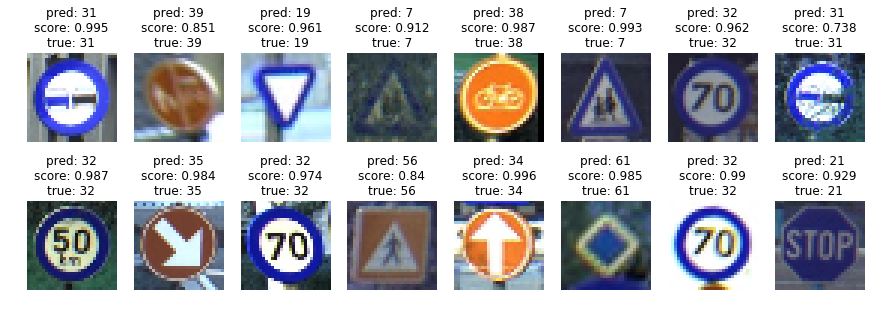

In [19]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = y_pred_test_classes[random_index]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = y_test[random_index, 0]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Test accuracy:", (accuracy_score(y_test, y_pred_test_classes))*100, "%")

Test accuracy: 98.13492063492063 %
